# Analysis

This notebook contains a general analysis workflow for spicy-snow data that is designed to be applied anywhere in the western US. 

In [1]:
# import required packages
# depending on your environment, you may need to install some of these
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import geopandas as gpd
import rasterio as rio
import datetime as dt
import requests
import pandas as pd
import sys
import contextily as cx
import seaborn as sns

### Load and prepare spicy snow depth data

In [2]:
# open spicy dataset as xarray dataset
ds = xr.open_dataset('./data/sd_2020-08-01_2021-07-31.nc')

# drop s1 for compatibility with rioxarray, which requires three coordinates
ds = ds.drop_vars('band')
ds = ds.drop('s1')

# reproject dataset to utm zone
crs = ds.rio.estimate_utm_crs()
ds = ds.transpose('time', 'y', 'x')
ds = ds.rio.reproject(crs)

# open aoi geojson as geopandas dataframe and reproject
aoi_fn = './east_river_basin_wgs.geojson'
aoi_gdf = gpd.read_file(aoi_fn).to_crs(crs)

# clip dataset to aoi
ds = ds.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)

Note that descending orbit 129 has incomplete coverage of the area of interest. We'll exclude that orbit during analysis

In [4]:
# exclude orbit without full coverage
ds = ds.where(ds.relative_orbit!=129.0, drop=True)

### Load SNOTEL data

First, we want to compare spicy-snow depths against available in-situ snow depth measurements. To do this, we pull in data from SNOTEL sites within some arbitrary distance of our area of interest. This should help us determine whether our snow depth estimates are reasonable and whether SNOTEL sites effectively represent distributed snow depths in the area of interest. 

In [5]:
# function to query SNOTEL api
def get_awdb_data(
    site_ids,
    server,
    elements=["TAVG","SNWD","WTEQ"],
    sdate=dt.datetime(1899, 10, 1),
    edate=dt.datetime.today() - dt.timedelta(days=1),
    orient="records",
    sesh=None,
):
    """
    Takes a list of site ids or a single site id and by default returns SWE period of record data as a single or list of dataframes,
    but user can pass args to modify data returned.
    Valid elements include WTEQ, SNWD, TAVG
    site_id takes the form of a triplet made from <network_site_id>:<state_abbrv>:<network> where network is either SNTL or MNST
    """
    # Create an emply list to hold the dataframe output
    dfs = []
    # Incase only one site id is passed as a string, this will put it in a list
    return_single = False
    if not isinstance(site_ids, list):
        site_ids = [site_ids]
        return_single = True
    # Iterate over the site ids
    for site_id in site_ids:
        # Iterate over each of the elements (TAVG, WTEQ, SNWD)
        for element in elements:
            # this determines what data we will grab, daily data in this case
            endpoint = "data/getDaily"
            # This next few lines builds the API request
            date_args = f"sDate={sdate:%Y-%m-%d}&eDate={edate:%Y-%m-%d}"
            frmt_args = f"format=json&orient={orient}"
            all_args = f"?triplet={site_id}&{date_args}&element={element}&{frmt_args}"
            url = f"{server}/{endpoint}{all_args}"
            # This prints output to tell us what we are working on building
            print(
                f"getting data for {site_id} {element} starting {sdate:%Y-%m-%d} "
                f"and ending {edate:%Y-%m-%d}"
            )
            # This builds the column names
            data_col_lbl = f"{element}"
            # This makes the actual API requests
            if sesh:
                req = sesh.get(url)
            else:
                req = requests.get(url)
            if req.ok:
                df = pd.DataFrame.from_dict(req.json())
                df.columns = [data_col_lbl,"Date"]
                df.set_index("Date", inplace=True)
            else:
                print("  No data returned!")
                df = (
                    pd.DataFrame(
                        data=[{"Date": pd.NaT, data_col_lbl: np.nan}],
                    )
                    .set_index("Date")
                    .dropna()
                )
            # Append the dataframe that was built and return
            dfs.append(df)
        if return_single:
            return dfs[0]
    return dfs

In [6]:
# function to download data for SNOTEL sites within some buffer distance of the site. 
def grab_snotel(aoi_gdf,
                buffer=1000,
                elements=["TAVG","SNWD","WTEQ"]
):
    '''
    Takes a geodataframe containing an area of interest and returns SNOTEL data from 
    stations within some distance of that area of interest. Geodataframe assumed to 
    be projected in appropriate utm zone. 
    '''
    # get SNTL data using an API built by Beau Uriona
    AWDB_API_DOMAIN = "https://api.snowdata.info"

    # pull in metadata for all NRCS SNOTEL sites
    sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"
    sntl_gdf = gpd.read_file(sntl_meta_url).to_crs(aoi_gdf.crs)

    # find sites within some distance of aoi
    buf_gdf = aoi_gdf.copy(deep=True)
    buf_gdf['geometry'] = buf_gdf.buffer(buffer)
    sntl_gdf = gpd.overlay(sntl_gdf, buf_gdf, how='intersection')
    
    # raise error if no site are found
    if sntl_gdf.empty:
        raise Exception(f'No SNOTEL sites within {buffer}m of aoi. Try a larger buffer.') 
    
    # build dict with station names and ids
    site_ids = list(sntl_gdf.stationTriplet)
    
    # download snotel data
    sntl_dfs = get_awdb_data(site_ids, server=AWDB_API_DOMAIN)
    
    # Make the index a datetime
    for i,df in enumerate(sntl_dfs):
        df.index = pd.to_datetime(df.index)
        sntl_dfs[i] = df

    # create a dictionary for conversion to xarray
    sntl_df_dict = {}
    counter = 0
    for i, site in enumerate(site_ids):
        sntl_df_dict[site_ids[i]] = pd.concat(sntl_dfs[counter:counter+len(elements)], 
                                              axis=1).sort_index().to_xarray()
        counter+=len(elements)
    
    # convert to xarray
    sntl_ds = xr.concat(sntl_df_dict.values(), pd.Index(sntl_df_dict.keys(), name='Location'))
    
    return sntl_ds, sntl_gdf

In [7]:
# get snotel data
sntl_ds, sntl_gdf = grab_snotel(aoi_gdf)
# convert to meters
sntl_ds['SNWD'] = sntl_ds['SNWD']*0.0254

getting data for 380:CO:SNTL TAVG starting 1899-10-01 and ending 2023-05-23
getting data for 380:CO:SNTL SNWD starting 1899-10-01 and ending 2023-05-23
getting data for 380:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-05-23
getting data for 737:CO:SNTL TAVG starting 1899-10-01 and ending 2023-05-23
getting data for 737:CO:SNTL SNWD starting 1899-10-01 and ending 2023-05-23
getting data for 737:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-05-23


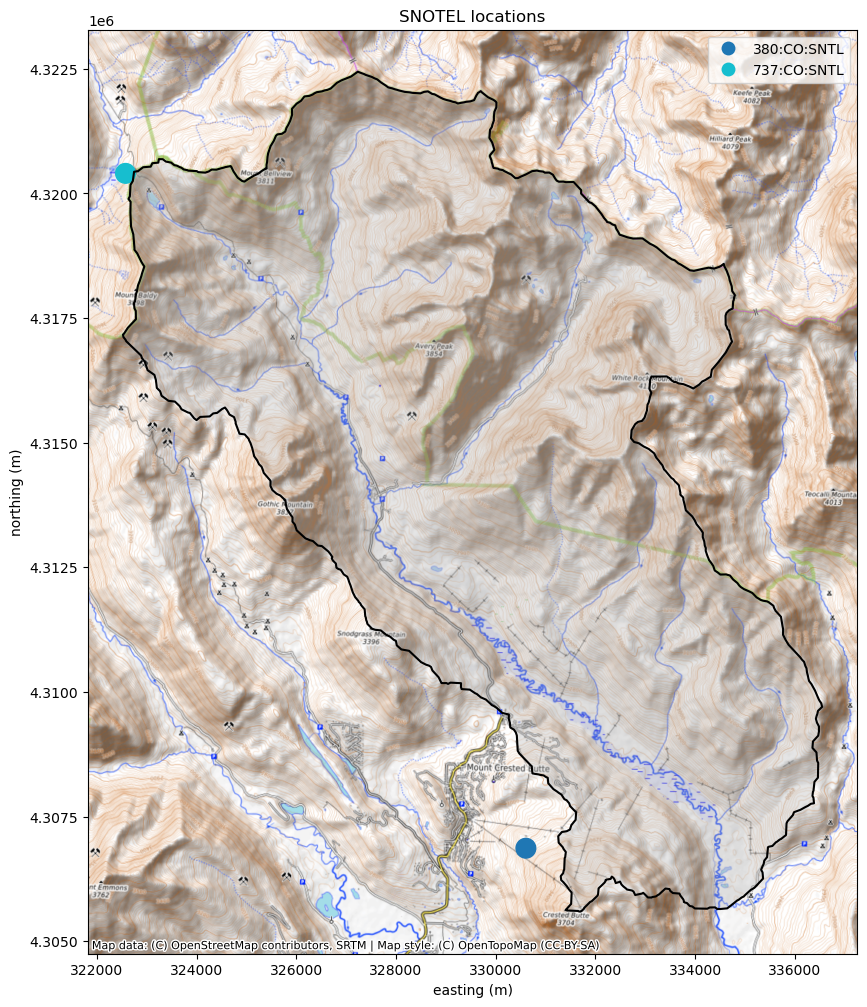

In [8]:
# map SNOTEL stations and area of interest. 
f, ax = plt.subplots(figsize=(12,12))
# Plot aoi polygon
aoi_gdf.plot(ax=ax,
             color='darkgrey',
             alpha=0.3,
             zorder=1)
aoi_gdf.boundary.plot(ax=ax,
                      color='k')
# Plot SNTL locations
sntl_gdf.plot(markersize=200,
              ax=ax,
              column=sntl_gdf.stationTriplet,
              cmap='tab10',
              legend=True)

cx.add_basemap(ax=ax, crs=aoi_gdf.crs.to_string(), source=cx.providers.OpenTopoMap);
ax.set_xlabel('easting (m)');
ax.set_ylabel('northing (m)');
ax.set_title('SNOTEL locations');

The map above gives us intuition for interpreting how our spicy-snow estimates will compare to snow depths measured by the SNOTEL sites. Note that
- The SNOTEL sites are outside of the aoi.
- One of the SNOTEL sites is at a higher elevation than the other.

Next, we can plot mean snow depth across our aoi against snow depth measured by the SNOTEL stations. 

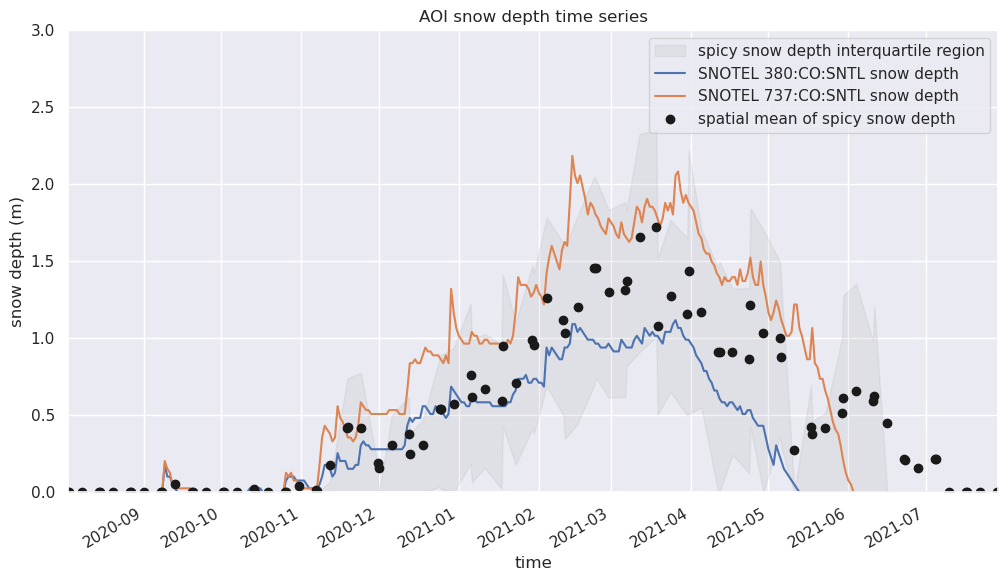

In [9]:
# plot snow depth time series
sns.set_theme()
f, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(ds.snow_depth.quantile(q=0.25, dim=['x', 'y']).dropna(dim='time').time,
                ds.snow_depth.quantile(q=0.25, dim=['x', 'y']).dropna(dim='time').values,
                ds.snow_depth.quantile(q=0.75, dim=['x', 'y']).dropna('time').values,
                alpha=0.1, color='Grey', label='spicy snow depth interquartile region')
for site in sntl_ds.Location:
    sntl_ds.sel(Location=site).SNWD.plot(label=f'SNOTEL {site.values} snow depth')
ds.snow_depth.mean(dim=['x', 'y']).plot(marker='o', linestyle='', c='k', label='spatial mean of spicy snow depth')
ax.set_xlim(ds.snow_depth.time[0], ds.snow_depth.time[-1])
ax.set_ylim(0, 3)
ax.set_ylabel('snow depth (m)')
ax.legend()
ax.set_title('AOI snow depth time series')

plt.savefig('./figs/sd_ts.png', dpi=300)

It seems like the spatial mean spicy-snow depth generally agrees with the snow depths at the SNOTEL sites. To get a better sense of how well the spatial mean is correlated with measurements from the SNOTEL sites, plot them against one another. 

In [10]:
# select SNOTEL measurements during Sentinel-1 overpass
sntl_ds_overpass = sntl_ds.sel(Date=ds.snow_depth.time, method='nearest')

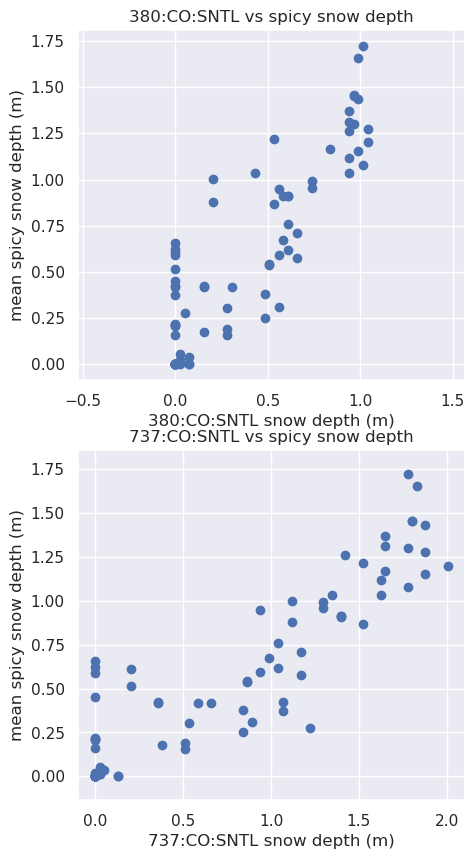

In [11]:
# plot spicy vs snotel snow depths
f, ax = plt.subplots(len(sntl_ds.Location), 1, figsize=(5, len(sntl_ds.Location)*5))
for i, site in enumerate(sntl_ds.Location):
    ax[i].scatter(sntl_ds_overpass.sel(Location=site).SNWD, ds.snow_depth.mean(dim=['x', 'y']))
    ax[i].set_aspect('equal', 'datalim')
    ax[i].set_title(f'{site.values} vs spicy snow depth')
    ax[i].set_xlabel(f'{site.values} snow depth (m)')
    ax[i].set_ylabel('mean spicy snow depth (m)')
    
plt.savefig('./figs/snotelvspicy.png', dpi=300)

Snow depths from SNOTEL and spicy-snow appear to be correlated. Remember that these measurements are not for the exact same location, so we expect some degree of bias and spread in the relationship. This comparison begs the question--Is spicy-snow or the SNOTEL sites more represenative of snow depth in the Upper East River Basin? To attemt to investigate this question, we'll see which measurements do a better job at representing the total amount of water in the basin using stream gage data. 

### Total water storage from spicy-snow

First, let's identify the peak water storage as indicated by spicy-snow. We there are multiple ways to approach this--we have gaps caused by incomplete satellite coverage and wet snow and we have to make some assumption about snow density. Here, we take a simple approach, choosing not to interpolate gaps and assuming a constant snow density of 0.3 g/cm^3. Our estimates of snow storage will likely be underestimates, as we are only including water stored in dry snow. 

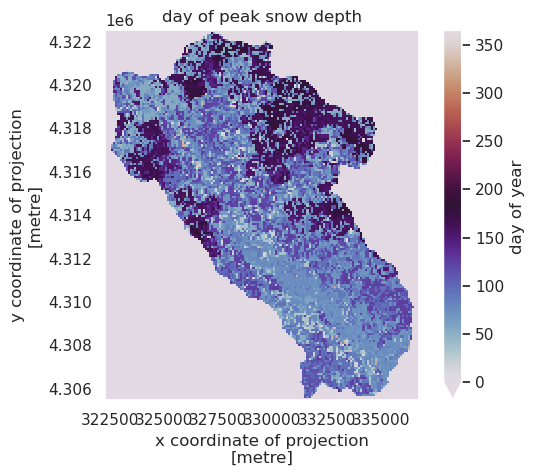

In [12]:
# when is peak storage for each pixel in our map?
f, ax = plt.subplots()
ds.snow_depth.idxmax(dim='time', skipna=True).dt.dayofyear.plot(ax=ax, 
                                                                cmap='twilight', 
                                                                vmin=0, vmax=365, 
                                                                cbar_kwargs={'label':'day of year'})
ax.set_title('day of peak snow depth')
ax.set_aspect('equal')

plt.savefig('./figs/peak_snow_day.png', dpi=300)

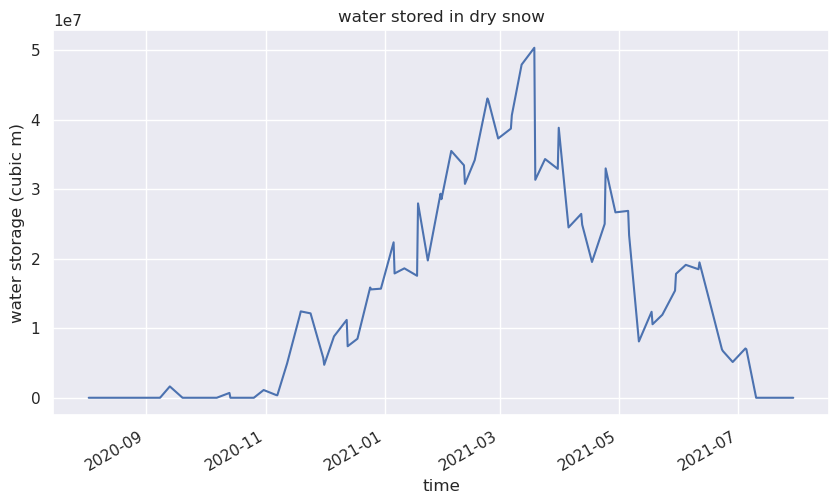

In [13]:
# assume a snow density of 0.3 g/cm^3
w_content = 0.3

# plot water storage over time
f, ax = plt.subplots(figsize=(10, 5))
(ds.snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).plot(ax=ax)
ax.set_ylabel('water storage (cubic m)')
ax.set_title('water stored in dry snow')

plt.savefig('./figs/water_storage.png', dpi=300)

In [14]:
print('date of max storage: ',
      (ds.snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).idxmax('time').dt.date.item(), 
      '\nmax storage (m^3): ',
      round((ds.snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).max().item(), -2),
      '\nmax storage flight direction: ',
      (ds.snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).idxmax().flight_dir.item(),
      '\nmax storage relative orbit: ',
      (ds.snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).idxmax().relative_orbit.item())

date of max storage:  2021-03-18 
max storage (m^3):  50342000.0 
max storage flight direction:  descending 
max storage relative orbit:  56.0


We find that maximum water storage occurs on March 18.

### Load stream gauge data

Now, we'll load data from a nearby stream gauge to assess how well runoff agrees with the timing and volume of water storage calculated using spicy-snow. First, we need to decide which stream gauge is most appropriate. 

In [15]:
# install USGS stream data retrieval package
!{sys.executable} -m pip install dataretrieval

In [16]:
import dataretrieval.nwis as nwis

In [17]:
# function to get bbox around aoi
def gage_bbox(gdf, buffer=15000):
    buf_gdf = gdf.copy(deep=True)
    buf_gdf['geometry'] = buf_gdf.buffer(buffer)
    bbox = [round(elem, 3) for elem in buf_gdf.to_crs(4326).bounds.values[0].tolist()]
    return bbox

In [18]:
bbox = gage_bbox(aoi_gdf)
# search for stream sites in the vicinity 
nwis_df = nwis.get_info(bBox=bbox,
                        siteType='ST',
                        startDT=ds.time[0].dt.strftime('%Y-%m-%d').item(),
                        endDT=ds.time[-1].dt.strftime('%Y-%m-%d').item())[0]

nwis_gdf = gpd.GeoDataFrame(
    nwis_df, geometry=gpd.points_from_xy(nwis_df.dec_long_va, nwis_df.dec_lat_va), crs="EPSG:4326").to_crs(crs)

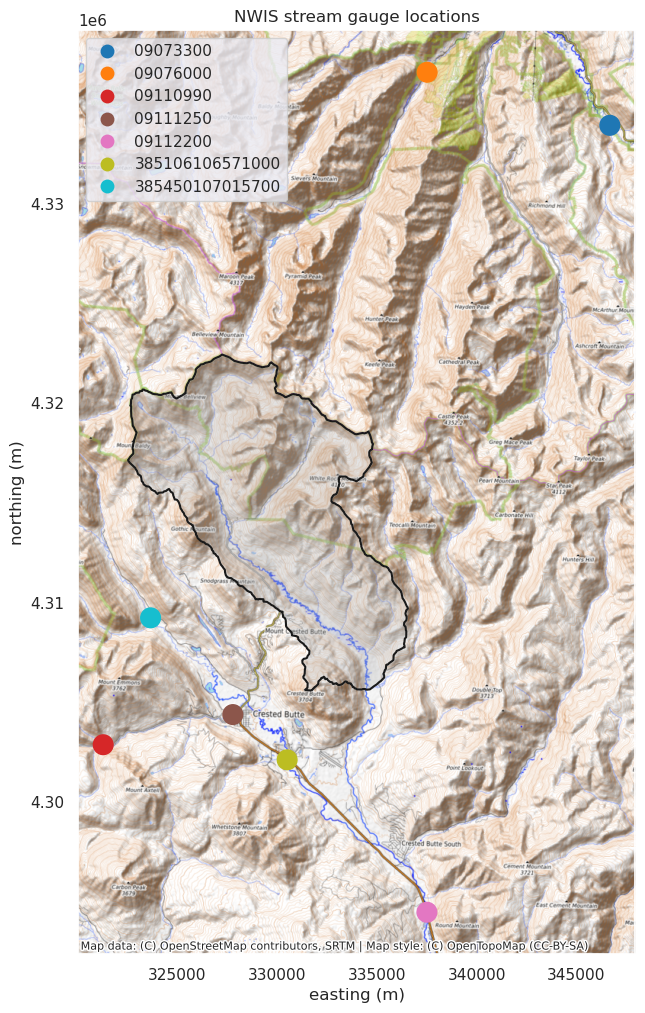

In [19]:
# Initialize Figure
f, ax = plt.subplots(figsize=(12,12))
# Plot aoi polygon
aoi_gdf.plot(ax=ax,
             color='darkgrey',
             alpha=0.3,
             zorder=1)
aoi_gdf.boundary.plot(ax=ax,
                      color='k')
# Plot SNTL locations
nwis_gdf.plot(markersize=200,
              ax=ax,
              column=nwis_gdf.site_no,
              cmap='tab10',
              legend=True)

cx.add_basemap(ax=ax, crs=aoi_gdf.crs.to_string(), source=cx.providers.OpenTopoMap);
ax.set_xlabel('easting (m)');
ax.set_ylabel('northing (m)');
ax.set_title('NWIS stream gauge locations');
plt.grid(False)

For now, we need to manually identify which stream gauge measures water coming from our area of interest. Here, the best stream gauge is 09112200. 

In [20]:
# examine info for chosen gauge
gauge_id = '09112200' # NEED TO SET THIS MANUALLY
nwis_gdf.loc[nwis_gdf['site_no']==gauge_id].transpose()

,4
agency_cd,USGS
site_no,09112200
station_nm,EAST RIVER BELOW CEMENT CREEK NR CRESTED BUTTE...
site_tp_cd,ST
lat_va,384703.0
long_va,1065213.0
dec_lat_va,38.78416
dec_long_va,-106.870874
coord_meth_cd,M
coord_acy_cd,S


In [21]:
gauge_df, gauge_md = nwis.get_dv(sites=gauge_id,
                           start=ds.time[0].dt.strftime('%Y-%m-%d').item(),
                           end=ds.time[-1].dt.strftime('%Y-%m-%d').item())

In [22]:
# calculate total discharge per day in m^3
gauge_df['total_flow'] = gauge_df['00060_Mean']*86400*0.0283168

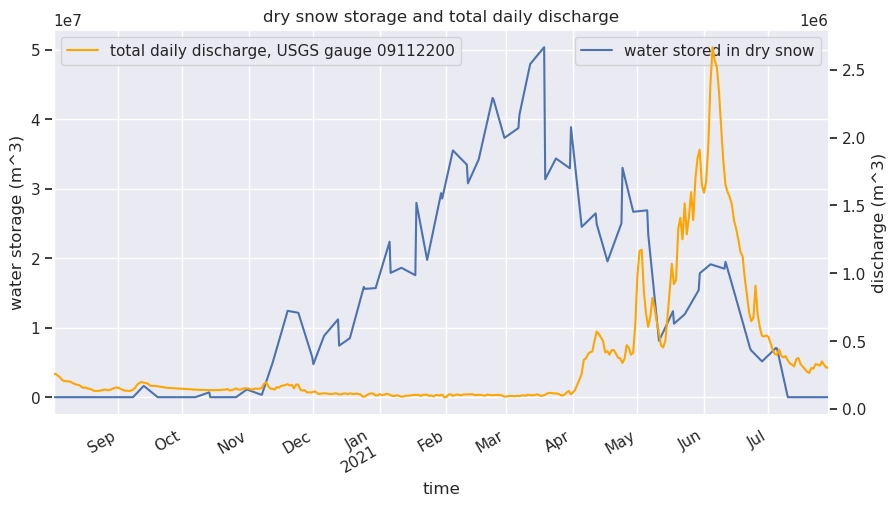

In [23]:
# plot water storage and streamflow over time
f, ax = plt.subplots(figsize=(10, 5))
(ds.snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).plot(ax=ax, label='water stored in dry snow')
ax.set_ylabel('water storage (m^3)')
ax.set_title('dry snow storage and total daily discharge')
ax.legend()

ax2 = ax.twinx() 
(gauge_df['total_flow']).plot(ax=ax2, c='orange', label=f'total daily discharge, USGS gauge {gauge_id}')
ax2.set_ylabel('discharge (m^3)')
ax2.legend()

plt.grid(False)

plt.savefig('./figs/water_storage_streamflow.png', dpi=300)

In [24]:
# what portion of total yearly discharge is stored as snow in the Upper East River Basin?
print(round((ds.snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).max().item()/gauge_df['total_flow'].sum(), 2))

0.39
